In [2]:
%load_ext autoreload
from einops import rearrange
from glob import glob
import torch
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
from torch.nn import L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
from models.perciever import Perceiver
from models.perciever_rnn import PerceiverRNN, MLPPredictor
from data_prep.nvidia import NvidiaDatasetRNN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pmodel = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 1,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 256,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 512,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    num_classes = 1,          # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

steering_classifier = MLPPredictor(512, 64)

In [8]:
BATCH_SIZE=16
NUM_WORKERS=2
SEQ_LENGTH=8
STRIDE=4

# RNN dataloader

dataset_path = Path('./data_stuff/rally-estonia-cropped-antialias')
#dataset_path = Path('/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias')
random.seed(42)
data_dirs = os.listdir(dataset_path)[0:12]
random.shuffle(data_dirs)
split_index1 = int(0.4 * len(data_dirs))
split_index2 = int(0.5 * len(data_dirs))

train_paths = [dataset_path / dir_name for dir_name in data_dirs[:split_index1]]
valid_paths = [dataset_path / dir_name for dir_name in data_dirs[split_index1:split_index2]]

train_dataset = NvidiaDatasetRNN(train_paths, SEQ_LENGTH, STRIDE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=True, collate_fn=train_dataset.collate_fn)
print('Validation set...')
valid_dataset = NvidiaDatasetRNN(valid_paths, SEQ_LENGTH, STRIDE)
print('Dataset ready')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=False, collate_fn=train_dataset.collate_fn)

[NvidiaDataset] Using transform from argument: Compose(
)
data_stuff\rally-estonia-cropped-antialias\2021-05-28-15-17-19_e2e_sulaoja_20_30: length=3218, filtered=0
data_stuff\rally-estonia-cropped-antialias\2021-05-20-13-59-00_e2e_sulaoja_10_10: length=687, filtered=1
data_stuff\rally-estonia-cropped-antialias\2021-05-20-12-51-29_e2e_sulaoja_20_30: length=5393, filtered=0
data_stuff\rally-estonia-cropped-antialias\2021-05-28-15-19-48_e2e_sulaoja_20_30: length=10708, filtered=0
Validation set...
[NvidiaDataset] Using transform from argument: Compose(
)
data_stuff\rally-estonia-cropped-antialias\2021-06-07-14-06-31_e2e_rec_ss6: length=3003, filtered=0
data_stuff\rally-estonia-cropped-antialias\2021-05-28-15-07-56_e2e_sulaoja_20_30: length=15626, filtered=0
Dataset ready


In [9]:
batch = next(iter(train_loader)) 

images = batch[0]['image'] # shape B, T, C, H, W
targets = batch[1] # shape B, T

images = rearrange(images, 'b t c h w -> t b h w c')
targets = rearrange(targets, 'b t -> t b')
latents = None
percieverRNN = PerceiverRNN(pmodel, steering_classifier, use_dino=True)

Using cache found in C:\Users\Gordei/.cache\torch\hub\facebookresearch_dinov2_main


In [33]:
from torch.nn.functional import pad
import math
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
image_preprocess = dinov2_vits14
for t in range(images.shape[0]):
    t_img_batch = images[t]
    t_img_batch = rearrange(t_img_batch, 'b h w c -> b c h w')
    height = t_img_batch.shape[2]
    width = t_img_batch.shape[3]

    patch_size = 14
    pad_height = (patch_size - height % patch_size) % patch_size
    pad_width = (patch_size - width % patch_size) % patch_size
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    out_h = math.floor((height + 2 * pad_height - patch_size) / 14) + 1
    out_w = math.floor((width + 2 * pad_width - patch_size) / 14) + 1

    t_img_batch = pad(t_img_batch, (pad_left, pad_right, pad_top, pad_bottom))
    #t_img_batch = rearrange(t_img_batch, 'b c h w  -> b h w c')
    print(t_img_batch.shape)
    preproc_image_batch = image_preprocess.patch_embed.forward(t_img_batch)
    print(preproc_image_batch.shape)
    print(out_h, out_w)
    #steering, latents = percieverRNN.forward(t_img_batch)

Using cache found in C:\Users\Gordei/.cache\torch\hub\facebookresearch_dinov2_main


torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19
torch.Size([16, 3, 70, 266])
torch.Size([16, 95, 384])
5 19


: 

In [8]:
targets.shape

torch.Size([8, 512])

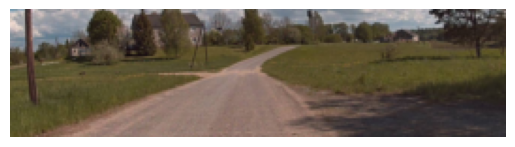

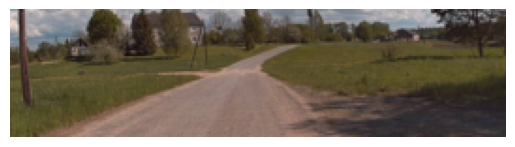

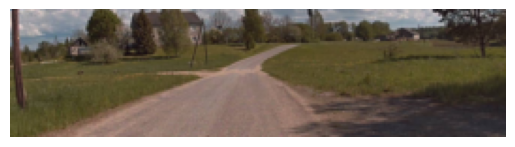

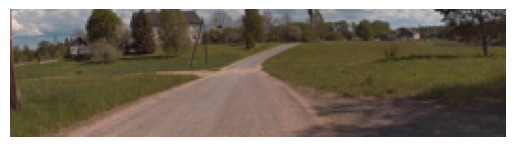

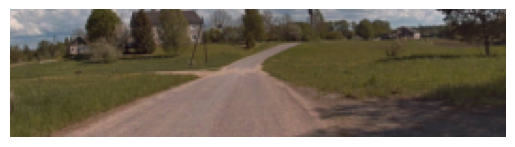

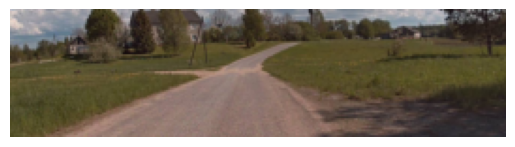

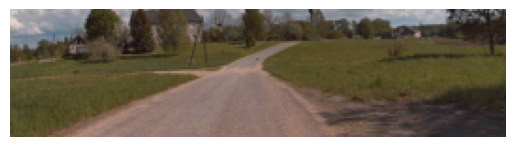

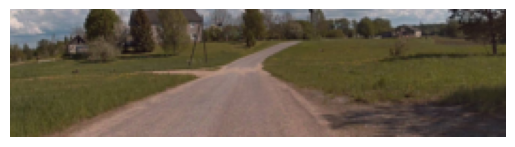

In [16]:
tens = next(iter(train_loader))[0]['image'][0]
for i in range(len(tens)):
    plt.imshow(tens[i].permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [32]:
import torch
from PIL import Image
import requests
import torchvision.transforms as transforms

# Load the pre-trained DINOv2 model from Torch Hub
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# Define the image preprocessing function
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Load an example image
url = "https://hips.hearstapps.com/hmg-prod/images/small-fluffy-dog-breeds-maltipoo-66300ad363389.jpg?crop=0.668xw:1.00xh;0.151xw,0&resize=640:*"
image = Image.open(requests.get(url, stream=True).raw)

# Preprocess the image
preprocessed_image = preprocess_image(image)
print(preprocessed_image.shape)  # Should be (1, 3, 224, 224)

# Perform inference
outputs = dinov2_vits14.patch_embed(preprocessed_image)

# The output could be the last hidden states or other relevant outputs depending on the model's architecture
print("Output shape:", outputs.shape)

Using cache found in C:\Users\Gordei/.cache\torch\hub\facebookresearch_dinov2_main


torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 256, 384])


In [29]:
print(dinov2_vits14.patch_embed.forward(preprocessed_image))

tensor([[[-0.0658,  0.0446,  0.0654,  ...,  0.0209,  0.0100,  0.0111],
         [-0.0581,  0.0445,  0.0716,  ...,  0.0146,  0.0135,  0.0111],
         [-0.0633,  0.0443,  0.0646,  ...,  0.0178,  0.0178,  0.0111],
         ...,
         [-0.0317,  0.0448,  0.0478,  ...,  0.0169,  0.0222,  0.0090],
         [-0.0518,  0.0454,  0.0713,  ...,  0.0036,  0.0266,  0.0098],
         [-0.0637,  0.0454,  0.0813,  ...,  0.0078,  0.0229,  0.0103]]],
       grad_fn=<TransposeBackward0>)
